In [1]:
%cd /home/q123/Desktop/explo

import torch 
import gpytorch 
import logging
import logging.config

from src.helpers import setup_experiment
from src.gibo.optim import GIBOptimizer
from src.optim import BOptimizer
from src.config import get_configs

logging.config.fileConfig('logging.conf')
# create root logger
logger = logging.getLogger()

/home/q123/Desktop/explo


/home/q123/miniconda3/envs/explo/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from src.tester import Tester 

env_name = "Swimmer-v2"
kernel_name = "grid"

env_config,likelihood_config,kernel_config,_,_ = get_configs(env_name,kernel_name)
model,objective_env = setup_experiment(env_config,kernel_config,likelihood_config)
tester = Tester(model,objective_env,
                 local_opt ="/home/q123/Desktop/explo/local_optima/"+env_name,
                 use_opt_states = True,
                 delta =1e-1,
                 n_train=2,n_test=2,n_episodes=5)

train_data,train_pred,test_data,test_pred,tmp = tester.run()

/home/q123/miniconda3/envs/explo/lib/python3.8/site-packages/gym/envs/registration.py:505: UserWarning: WARN: The environment Swimmer-v2 is out of date. You should consider upgrading to version `v3` with the environment ID `Swimmer-v3`.
  logger.warn(


MathLog.src.helpers : WARNING : MLP dimensions : [8, 2]


AttributeError: cannot assign module before Module.__init__() call

In [ ]:
local_opt = tester.local_opt
r,states = objective_env(local_opt.reshape(1,-1),n_episodes=5)
print(states.shape)
print(model.covar_module.states.shape)

torch.Size([1001, 8])
torch.Size([500, 8])


In [ ]:
from src.tester import Tester 

env_name = "Swimmer-v2"
kernel_name = "rbf"

env_config,likelihood_config,kernel_config,_,_ = get_configs(env_name,kernel_name)
model,objective_env = setup_experiment(env_config,kernel_config,likelihood_config)
tester = Tester(model,objective_env,
                 "/home/q123/Desktop/explo/local_optima/"+env_name,1e-1,
                 
                 n_train=100,n_test=100,n_episodes=5)

train_data,train_pred,test_data,test_pred,tmp = tester.run()

MathLog.src.helpers : WARNING : MLP dimensions : [8, 2]


/home/q123/miniconda3/envs/explo/lib/python3.8/site-packages/gym/envs/registration.py:505: UserWarning: WARN: The environment Swimmer-v2 is out of date. You should consider upgrading to version `v3` with the environment ID `Swimmer-v3`.
  logger.warn(


TypeError: __init__() missing 1 required positional argument: 'delta'

In [ ]:
from src.tester import Tester 

env_name = "CartPole-v1"
kernel_name = "grid"

env_config,likelihood_config,kernel_config,_,_ = get_configs(env_name,kernel_name)
model,objective_env = setup_experiment(env_config,kernel_config,likelihood_config)
tester = Tester(model,objective_env,
                 "/home/q123/Desktop/explo/local_optima/"+env_name,1e-2,
                 n_train=10,n_test=10,n_episodes=5)

train_data,train_pred,test_data,test_pred,tmp = tester.run()

ModuleNotFoundError: No module named 'src'

MathLog.src.helpers : WARNING : MLP dimensions : [4, 1]
local_y 0.999994158744812 local_opt tensor([ 0.1845, -0.1644,  0.8678,  0.5544,  0.0036])
 intial local opt reward : 0.6513976782560349
Generating data
Done generating data
##############################
covar_lengthscale max 0.5 / min 0.5                  covar_outputscale 1.9999998807907104                 noise 0.3050000071525574
##############################
##############################
covar_lengthscale max 0.5307373404502869 / min 0.031301017850637436                  covar_outputscale 0.0383976586163044                 noise 0.012775972485542297
##############################


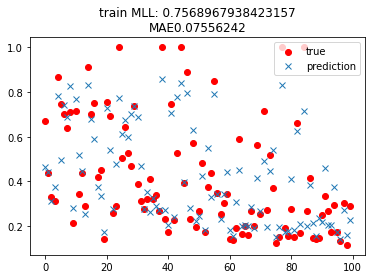

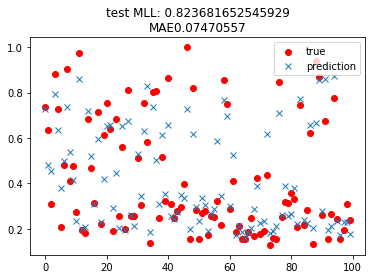

In [ ]:
from src.tester import Tester 

env_name = "CartPole-v1"
kernel_name = "rbf"

env_config,likelihood_config,kernel_config,_,_ = get_configs(env_name,kernel_name)
model,objective_env = setup_experiment(env_config,kernel_config,likelihood_config)
tester = Tester(model,objective_env,
                 "/home/q123/Desktop/explo/local_optima/"+env_name,1e-2,
                 n_train=100,n_test=100,n_episodes=5)

train_data,train_pred,test_data,test_pred,tmp = tester.run()

In [ ]:
params = torch.rand(5)

for i in range(10):
   reward,_ =objective_env(params)
   print(reward)

tensor([0.0200])
tensor([0.0200])
tensor([0.0200])
tensor([0.0220])
tensor([0.0220])
tensor([0.0200])
tensor([0.0220])
tensor([0.0220])
tensor([0.0180])
tensor([0.0220])
